# **Binding Affinity Prediction of Small Molecules Toward Human Immunodeficiency Virus**

## **Introduction**

The binding affinity of small molecules to target proteins is a critical determinant in drug discovery and development. Understanding and predicting these interactions can expedite the identification of potential therapeutic agents. In this project, we explore the binding affinity of small molecules toward the Human Immunodeficiency Virus (HIV) using a cheminformatics approach.

Our methodology involves leveraging diverse molecular fingerprinting techniques, including:

- **MACCS Keys**: A predefined set of structural subfeatures used for rapid screening.
- **Avalon Fingerprints**: Highly customizable fingerprints tailored for chemical informatics tasks.
- **Morgan Fingerprints**: Circular fingerprints based on the Extended Connectivity Fingerprint (ECFP) algorithm, commonly used in QSAR studies.
- **Atom-Pair Fingerprints**: Representing molecular features based on bonded atom pairs.
- **Topological Torsional Fingerprints**: Encoding information about torsional angles in molecular topologies.

To enhance predictive performance and reduce computational complexity, we also incorporate **dimensionality reduction** techniques. This hybrid approach aims to retain the most informative features while discarding redundancy, thereby improving model interpretability and efficiency.

By combining these advanced cheminformatics techniques with robust dimensionality reduction methods, this project seeks to uncover meaningful patterns in molecular data and accurately predict binding affinities. The findings aim to contribute to the development of novel therapeutics for combating HIV.

---


In [2]:
# Import necessary libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# RDKit libraries for cheminformatics
from rdkit import Chem
from rdkit.Chem import Draw, AllChem, rdMolDescriptors
from rdkit.Chem import PandasTools

# Scikit-learn libraries for machine learning and preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# Loading the data (The data is been collected and structured from the BindingDB Database: )
data = pd.read_csv("binding_affinity.csv")

In [4]:
data.head()  # Loading the first rows of the dataset

smiles  \
0  Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C...   
1  O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...   
2  CC(C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccccc1)[C@@...   
3  CCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1)[...   
4  COCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1...   

                      target_name standard_type    value  
0                    Homo sapiens          IC50   >50000  
1                             NaN          IC50   6676.9  
2  Human immunodeficiency virus 1          IC50      8.5  
3  Human immunodeficiency virus 1          IC50      177  
4  Human immunodeficiency virus 1          IC50      164

### Feature Extraction: Processing the `value` Column

The provided line of code performs the following steps to process and clean the `value` column in the dataset:

1. **Replace Symbols (`>` and `<`)**:
   - The `replace` method is applied to the `value` column to remove the symbols `>` and `<`.
   - This is achieved using the `regex=True` argument, which interprets the pattern as a regular expression.
   - As a result, any occurrence of `>` or `<` in the values of the column is replaced with an empty string (`""`).

2. **Convert to `float` Data Type**:
   - After removing the symbols, the column values are converted to the `float` data type using the `astype(float)` method.
   - This ensures the column can be used for numerical computations, as the presence of symbols like `>` or `<` would have made it non-numeric.

### Purpose:
This step is part of feature extraction and data cleaning:
- It prepares the data for numerical analysis or machine learning by ensuring the `value` column contains clean and numeric data.
- Removing symbols like `>` or `<` can be crucial when these symbols are artifacts or indicators that are no longer needed for analysis.

#### Code:
```python
data['value'] = data['value'].replace({">": "", "<": ""}, regex=True).astype(float)


In [6]:
# Feature extraction from the object data-type of the value column
data['value'] = data['value'].replace({">":"","<":""},regex=True).astype(float)

In [7]:
print(data['target_name'].unique())  # all unique target molecules

['Homo sapiens' nan 'Human immunodeficiency virus 1' ...
 '14-3-3 protein theta' 'Chromobox protein homolog 3'
 'Major pollen allergen Bet v 1-A']


In [8]:
data['target_name'].nunique()  # Number of unique targets

4421

### Filtering HIV Data for Analysis

The provided code filters the dataset to retain only rows where the `target_name` column contains the substring `"Human immunodeficiency virus"`. This is achieved as follows:

1. **String Matching**:
   - The `str.contains` method is used to check whether the substring `"Human immunodeficiency virus"` appears in the `target_name` column.
   - The `na=False` argument ensures that any `NaN` values in the column are treated as `False` during the filtering process, preventing errors.

2. **Sub-String Matching for Variants**:
   - The filter is based on the substring `"Human immunodeficiency virus"`, which means it will match various variants or forms of the virus name that include this string.
   - For example, entries like `"Human immunodeficiency virus type 1 (HIV-1)"`, `"Human immunodeficiency virus type 2 (HIV-2)"`, or `"Human immunodeficiency virus subtype B"` will all be included in the filtered dataset.
   - This ensures flexibility in capturing different classifications or naming conventions associated with HIV.

3. **Purpose**:
   - The filtering step focuses the analysis specifically on HIV-related data by isolating rows with relevant target names. This is often critical in domain-specific analyses, such as in virology or epidemiology.

#### Code:
```python
hiv_data = data[data['target_name'].str.contains("Human immunodeficiency virus", na=False)]


In [10]:
# Filtering HIV data for analysis 
hiv_data = data[data['target_name'].str.contains("Human immunodeficiency virus", na=False)]

In [11]:
hiv_data.shape  # Dimension of the data

(22409, 4)

In [12]:
hiv_data['standard_type'].value_counts()  # Different unit's to measure the binding affinity of the drug

IC50    16179
Ki       4420
EC50     1579
Kd        231
Name: standard_type, dtype: int64

### What are IC50 Values?

**IC50 (Inhibitory Concentration 50%)** is a measure commonly used in pharmacology and drug development. 

- It refers to the concentration of a substance (such as a drug or inhibitor) that is required to inhibit a biological or biochemical function by 50%.
- In the context of HIV data, the IC50 value typically indicates the concentration of an anti-HIV drug needed to reduce the viral activity by half.
- The lower the IC50 value, the more potent the compound, as it requires a lower concentration to inhibit the viral activity.
- IC50 values are crucial in evaluating the effectiveness of antiviral drugs in inhibiting the replication of the virus.

### Purpose of Filtering for IC50

By filtering the data for IC50 values, this step ensures that we focus specifically on the data related to the potency of compounds or drugs against HIV. 

- IC50 values are often used to compare the efficacy of different drugs or to track how a virus strain responds to treatment.

### Example Use Cases:

- **Drug Screening**: Identifying the most effective drugs based on their IC50 values.
- **Resistance Studies**: Determining how different HIV strains may exhibit resistance to drugs by analyzing changes in their IC50 values.


In [14]:
hiv_data_ic50 = hiv_data[hiv_data['standard_type']=='IC50']  # Filter the data for the IC50 values only

### Why Clip the IC50 Values?

#### Handling Extreme Values (Outliers):

The `clip` function is used to restrict the IC50 values to a certain range. In this case:

- The **lower bound** is set to `1e-9` (a very small positive value), ensuring that no IC50 value is below this threshold. This prevents issues that may arise from zero or negative IC50 values, which are not realistic or meaningful in the context of drug potency.
- The **upper bound** is set to `1e6` (one million), ensuring that no IC50 value exceeds this value. Extremely high IC50 values (which could represent ineffective drugs) may be outliers that would distort the analysis.

#### Improved Analysis:

- Clipping helps in reducing the influence of extreme outliers that could skew statistical analyses, machine learning models, or visualization results.
- By capping the values, the dataset becomes more stable, and the range of IC50 values becomes more manageable for downstream analysis, making it easier to identify trends and compare drug efficacies.

#### Preserving Meaningful Data:

- This transformation ensures that the dataset remains within a realistic and useful range for IC50 values, allowing for more effective comparisons and interpretations.


In [16]:
hiv_data_ic50.head()

smiles  \
2  CC(C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccccc1)[C@@...   
3  CCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1)[...   
4  COCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1...   
5  COCCOCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccc...   
6  COC(=O)N[C@@H](C(C)C)C(=O)NN(C[C@H](O)[C@H](Cc...   

                      target_name standard_type  value  
2  Human immunodeficiency virus 1          IC50    8.5  
3  Human immunodeficiency virus 1          IC50  177.0  
4  Human immunodeficiency virus 1          IC50  164.0  
5  Human immunodeficiency virus 1          IC50   67.0  
6  Human immunodeficiency virus 1          IC50   27.0

### pIC50

**pIC50** is the negative logarithm of the IC50 value, commonly used in pharmacology to express the potency of a drug or compound. It is calculated as:


#### Purpose of Using pIC50:

1. **Logarithmic Scale**: 
   - IC50 values are often expressed in a wide range of concentrations, from very low to very high. Using the logarithmic scale helps to condense this range into more manageable values. For example, an IC50 value of 1 nM and 100 μM would correspond to pIC50 values of 9 and 4, respectively, making it easier to compare the relative potencies.

2. **Enhanced Comparison**:
   - The pIC50 scale allows for more intuitive comparison of the potencies of different compounds, as higher pIC50 values indicate more potent drugs (i.e., lower IC50 values). This simplifies the analysis and interpretation of drug efficacy.

3. **Better Distribution**:
   - The conversion of IC50 to pIC50 often results in a more normal distribution of data, which is beneficial for statistical analyses and modeling, especially in machine learning applications.

4. **Convenience**:
   - The use of pIC50 is common in scientific literature and databases, allowing for standardized reporting of drug potencies. It also helps avoid dealing with extremely small or large IC50 values in calculations or visualizations.

#### Example:

If a compound has an IC50 value of 10 nM, the pIC50 would be:
pIC50 = -log10(10 nM) = 8

This indicates a potent drug, as the pIC50 value is high, meaning that the IC50 is low.

### Formula:
pIC50 = -log10(IC50)

In [18]:
# Calculate pIC50 from IC50 values
hiv_data_ic50['pIC50'] = -np.log10(hiv_data_ic50['value'])

C:\Users\Gharat\AppData\Local\Temp\ipykernel_28096\3444087007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hiv_data_ic50['pIC50'] = -np.log10(hiv_data_ic50['value'])


### Why Canonicalizing the SMILES is Important

**SMILES (Simplified Molecular Input Line Entry System)** is a notation used to represent chemical structures as text strings. Canonicalizing SMILES is a crucial step in many cheminformatics workflows and has several key benefits:

#### 1. **Standardization and Consistency**:
   - SMILES strings can represent the same molecule in different ways due to variations in how atoms and bonds are written. For example, the same molecule might be written as `CCO` (ethanol) or `C(C)O` depending on the notation used. 
   - **Canonicalization** converts these different representations into a single, standard form, ensuring consistency across datasets and analyses. This makes it easier to compare molecules and perform database searches.

#### 2. **Accurate Molecular Comparisons**:
   - When analyzing a set of molecules, canonicalizing SMILES allows for accurate comparisons between molecules based on their true chemical structure. Without canonicalization, two chemically identical molecules might be represented with different SMILES strings, making them appear as distinct molecules in computational analyses.

#### 3. **Data Integrity**:
   - In large chemical databases, molecules can be stored and indexed in a variety of ways. Canonicalizing the SMILES ensures that a given molecule is consistently represented and indexed, helping to avoid duplicate entries and reducing errors in data retrieval.

#### 4. **Search Efficiency**:
   - Canonicalized SMILES allow for more efficient searching and querying of chemical databases. When searching for a particular molecule, canonicalization ensures that different representations of the same molecule do not lead to false negatives in search results.

#### 5. **Facilitating Machine Learning and Modeling**:
   - For machine learning models and computational tools that rely on molecular structures (e.g., virtual screening, molecular docking, and QSAR modeling), canonicalized SMILES strings ensure that the input data is consistent and that the models are trained on uniform representations of the molecules.
   
#### 6. **Improved Data Sharing and Collaboration**:
   - In collaborative research environments, different teams or labs may generate different representations of molecules. Canonicalization ensures that all parties are working with the same representation, facilitating smoother data sharing and collaboration.

### Conclusion:
Canonicalizing SMILES is essential for ensuring data consistency, reducing errors, improving search and comparison accuracy, and enabling efficient machine learning workflows. It ensures that the representation of chemical structures is uniform, leading to better data integrity and m


In [20]:
# Function to canonicalize SMILES string
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
        return canonical_smiles
    else:
        return None  # In case of invalid SMILES

hiv_data_ic50['canonical_smiles'] = hiv_data_ic50['smiles'].apply(canonicalize_smiles)

C:\Users\Gharat\AppData\Local\Temp\ipykernel_28096\4115114702.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hiv_data_ic50['canonical_smiles'] = hiv_data_ic50['smiles'].apply(canonicalize_smiles)


In [21]:

PandasTools.AddMoleculeColumnToFrame(hiv_data_ic50, 'canonical_smiles', 'structure')

C:\Users\Gharat\anaconda31\Lib\site-packages\rdkit\Chem\PandasTools.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


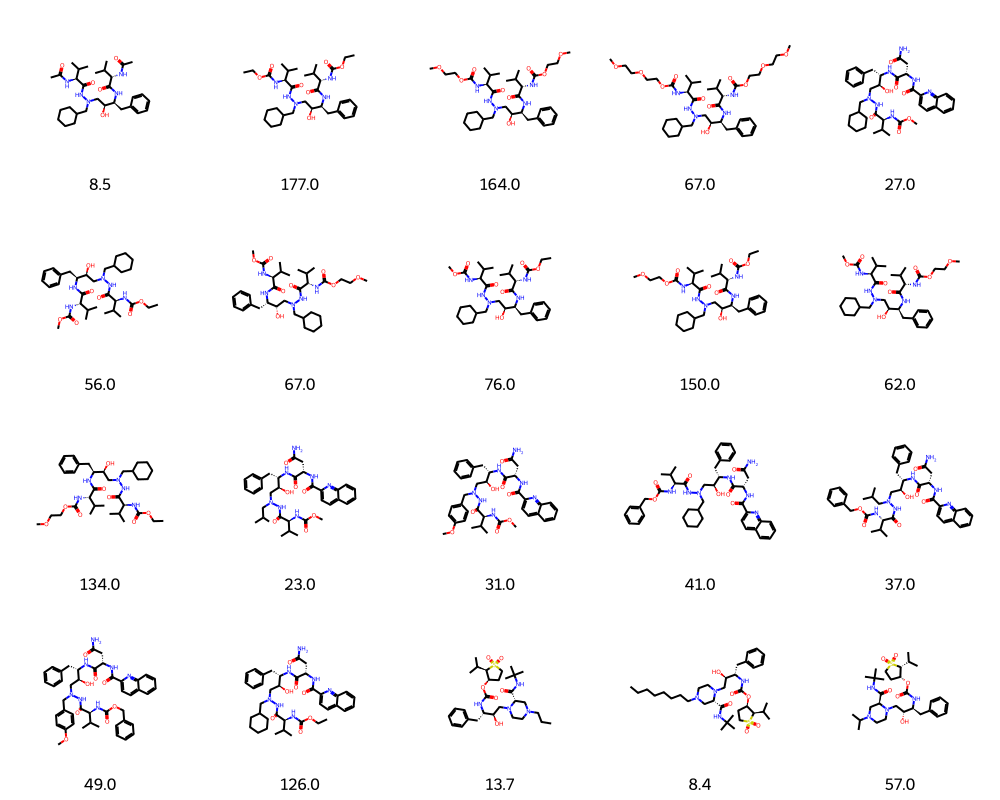

In [28]:
Draw.MolsToGridImage([x for x in hiv_data_ic50["structure"]][:20], maxMols=100, 
                     legends=[str(x) for x in hiv_data_ic50.value], subImgSize=(200,200), molsPerRow=5)

---

## MACCS Fingerprints and Their Use in Binding Affinity Prediction

### Overview of MACCS Fingerprints
MACCS (Molecular ACCess System) fingerprints are a widely used type of binary molecular descriptor that encode chemical information into a fixed-length vector. These fingerprints consist of 166 predefined structural features (or keys) that correspond to specific substructures, functional groups, or topological characteristics of a molecule. Each of the 166 bits in a MACCS fingerprint represents the presence or absence of a particular structural feature in the molecule.

### Key Features of MACCS Fingerprints
- **Structural Features**: MACCS fingerprints focus on simple, well-defined substructures that can be easily matched across different molecules. These include motifs like aromatic rings, functional groups (e.g., hydroxyl, amino, carboxyl), and other common structural elements.
- **Binary Encoding**: The fingerprint is represented as a binary string, where each bit corresponds to the presence (1) or absence (0) of a feature. This makes it easy to compare molecules using various machine learning algorithms.
- **Predefined Keys**: Unlike other fingerprinting methods, MACCS keys are predefined, which means that the same 166 features are used for all molecules, enabling consistent comparisons across different datasets.

### Application of MACCS Fingerprints in Binding Affinity Prediction

In the context of **binding affinity prediction**, the goal is to model the interaction between a ligand (small molecule) and a target protein, typically focusing on the strength of their binding. Accurate prediction of binding affinity is essential in drug discovery, as it helps identify promising compounds with high binding affinity to a target, potentially leading to effective drugs.

#### How MACCS Fingerprints Help in Binding Affinity Prediction
1. **Structural Representation of Molecules**: 
   Binding affinity is largely driven by the molecular structure of the ligand and how it fits within the target protein's binding site. MACCS fingerprints provide a compact and informative representation of the ligand's structure, capturing key features such as functional groups, aromatic rings, and other motifs known to play a role in molecular interactions.
   
2. **Recognition of Binding Motifs**: 
   Many binding interactions are governed by well-defined substructures. For example, hydrogen bond donors and acceptors, hydrophobic regions, and electrostatic interactions can all be encoded as specific keys in the MACCS fingerprint. This makes MACCS particularly useful for identifying common binding motifs across different ligands, facilitating the prediction of their binding affinity.

3. **Feature Reduction**: 
   Compared to more complex descriptors (e.g., molecular graphs or 3D descriptors), MACCS fingerprints provide a simple, fixed-length vector that can be used efficiently in machine learning models. This reduced dimensionality makes them a good starting point for building predictive models, while still maintaining key structural information.
   
4. **Compatibility with Machine Learning**:
   MACCS fingerprints are easily fed into machine learning algorithms like **Random Forests**, **Support Vector Machines (SVM)**, and **Neural Networks** to predict binding affinity. By training these models on a dataset of known ligands and their corresponding binding affinities, the models can learn to recognize which structural features (encoded in the MACCS fingerprint) are important for high or low binding affinity.
   
5. **Simplification of Complex Data**:
   In contrast to more computationally expensive descriptors (like 3D molecular structures or quantum mechanical calculations), MACCS fingerprints simplify the data, making them suitable for quick and cost-effective predictions. For binding affinity, where the focus is primarily on the ligand's structure rather than the dynamics of the protein-ligand interaction, MACCS offers an effective compromise.

### Practical Example: Using MACCS Fingerprints for Binding Affinity Prediction
Suppose we are working with a dataset of small molecules and their experimentally measured binding affinities to a specific protein target. The steps to use MACCS fingerprints in binding affinity prediction would typically include:

1. **Generate MACCS Fingerprints**:
   For each molecule in the dataset, generate its corresponding MACCS fingerprint using tools like RDKit or Open Babel.
   
   ```python
   from rdkit import Chem
   from rdkit.Chem import MACCSkeys

   # Example molecule
   mol = Chem.MolFromSmiles('CC(C)CC1=CC=CC=C1')  # Example SMILES for a molecule
   maccs_fp = MACCSkeys.GenMACCSKeys(mol)  # Generate MACCS fingerprint

   # Convert to list for machine learning models
   maccs_fp_list = list(maccs_fp)

In [31]:
# Generate MACCS Fingerprints
def get_maccs_fingerprint(mol):
    return rdMolDescriptors.GetMACCSKeysFingerprint(mol)

# Extract MACCS fingerprints
maccs_fps = [get_maccs_fingerprint(mol) for mol in hiv_data_ic50['structure']]

   Dataset Size  Time Taken (s)
0           100        0.365660
1           500        1.732415
2          1000        3.433232
3          2000        6.377868
4         16179       51.030929


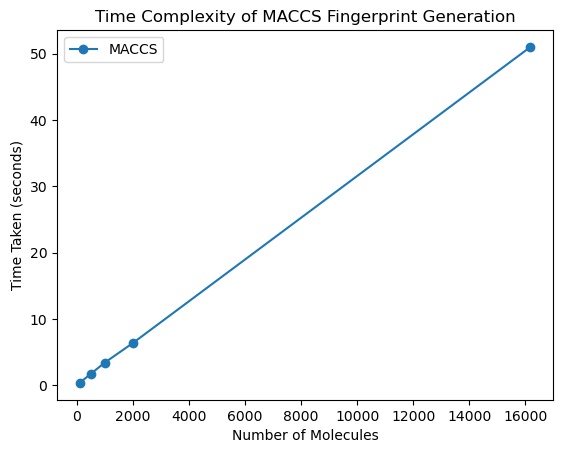

In [32]:
# Function to measure time for generating MACCS fingerprints
def measure_time_complexity_maccs(dataset):
    times = []
    sizes = [100, 500, 1000, 2000, len(dataset)]  # Adjust dataset sizes as needed
    for size in sizes:
        subset = dataset[:size]  # Take the first 'size' molecules
        start_time = time.time()
        fingerprints = [rdMolDescriptors.GetMACCSKeysFingerprint(mol) for mol in subset]
        end_time = time.time()
        times.append((size, end_time - start_time))
    return times

# Example usage (assuming hiv_data_ic50['structure'] contains RDKit Mol objects)
timing_results_maccs = measure_time_complexity_maccs(hiv_data_ic50['structure'])

# Convert results to DataFrame for visualization
import pandas as pd
timing_df_maccs = pd.DataFrame(timing_results_maccs, columns=['Dataset Size', 'Time Taken (s)'])
print(timing_df_maccs)

# Plotting the results
plt.plot(timing_df_maccs['Dataset Size'], timing_df_maccs['Time Taken (s)'], marker='o', label='MACCS')
plt.xlabel('Number of Molecules')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Complexity of MACCS Fingerprint Generation')
plt.legend()
plt.show()

C:\Users\Gharat\AppData\Local\Temp\ipykernel_28096\3198073206.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


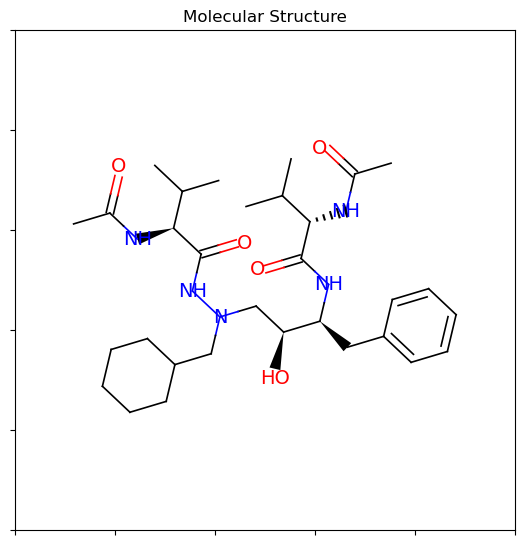

In [33]:
# Access the first molecule using .iloc[0] to get the first row in the DataFrame
first_mol = hiv_data_ic50.iloc[0]['structure']

# Draw the molecule structure
Draw.MolToMPL(first_mol, size=(200, 200), kekulize=True)
plt.title('Molecular Structure')
# Show the plot
plt.tight_layout()
plt.show()

In [34]:
# Convert the first MACCS fingerprint to bit vector and print it as a binary string
first_maccs_fp = maccs_fps[0]  # Get the first fingerprint

# Convert the fingerprint to a bit string (binary representation)
bit_vector = list(first_maccs_fp.ToBitString())

# Print the bit vector as a binary string
print("MACCS Fingerprint (Bit Vector) for first molecule:")
print(''.join(bit_vector))  # Output as a string of 0s and 1s

# Optionally, if you want it as a list of integers:
bit_vector_int = [int(bit) for bit in bit_vector]
print("\nMACCS Fingerprint as list of integers:")
print(bit_vector_int)

MACCS Fingerprint (Bit Vector) for first molecule:
00000000000000000000000000000000000000000000000000001110000000000000010000100001100000100011101101001000100000110000011000101000110110001011111001111101111111111111110

MACCS Fingerprint as list of integers:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [35]:
# Convert the MACCS fingerprints into a list of bit vectors (binary strings to list of 0s and 1s)
X_maccs = pd.DataFrame([list(map(int, fp.ToBitString())) for fp in maccs_fps])

# Define target variable
y = hiv_data_ic50['pIC50']

In [36]:
X_maccs.head()

0    1    2    3    4    5    6    7    8    9    ...  157  158  159  160  \
0    0    0    0    0    0    0    0    0    0    0  ...    1    1    1    1   
1    0    0    0    0    0    0    0    0    0    0  ...    1    1    1    1   
2    0    0    0    0    0    0    0    0    0    0  ...    1    1    1    1   
3    0    0    0    0    0    0    0    0    0    0  ...    1    1    1    1   
4    0    0    0    0    0    0    0    0    0    0  ...    1    1    1    1   

   161  162  163  164  165  166  
0    1    1    1    1    1    0  
1    1    1    1    1    1    0  
2    1    1    1    1    1    0  
3    1    1    1    1    1    0  
4    1    1    1    1    1    0  

[5 rows x 167 columns]

In [37]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_maccs, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# Prepare DataFrame to store results
results = []

# Loop over models
for model_name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Append the results to the dataframe
    results.append({
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

               Model       MAE       MSE      RMSE        R²
0      Random Forest  0.609797  0.731530  0.855295  0.732976
1  Linear Regression  0.990264  1.538986  1.240559  0.438237
2                SVR  0.688221  0.892136  0.944529  0.674351
3  Gradient Boosting  0.883043  1.251529  1.118717  0.543165
4      Decision Tree  0.667872  1.041055  1.020321  0.619993


## Advantages and Disadvantages of MACCS Fingerprints

### Advantages of MACCS Fingerprints

1. **Simplicity and Speed**:
   - **Efficient Representation**: MACCS fingerprints are binary and consist of a fixed-length vector (166 bits). This simplicity makes them computationally efficient to generate and compare, even for large datasets.
   - **Fast Calculation**: MACCS fingerprints can be quickly calculated using cheminformatics toolkits like RDKit, making them suitable for high-throughput screening or large-scale analyses.

2. **Predefined Structural Features**:
   - **Standardized Representation**: The 166 predefined structural features used in MACCS keys are consistent across all molecules, providing a standardized way to represent molecular structures. This helps in ensuring comparability between different datasets and experiments.
   - **Focus on Known Binding Motifs**: MACCS keys are designed to capture common substructures and functional groups, which are often important in predicting biological activity and binding affinity. This makes them particularly useful for identifying binding motifs across ligands.

3. **Compatibility with Machine Learning Models**:
   - **Feature Reduction**: Unlike more complex descriptors (e.g., molecular graphs or 3D coordinates), MACCS fingerprints provide a fixed-length vector representation that is ideal for input into machine learning models like Random Forests, Support Vector Machines (SVM), and Neural Networks.
   - **Interpretability**: As each bit in a MACCS fingerprint corresponds to a specific substructure, the generated fingerprints are relatively easy to interpret. This allows researchers to understand which molecular features are important for predicting binding affinity.

4. **Reduced Dimensionality**:
   - **Compact Representation**: The fixed-length nature of MACCS fingerprints (166 bits) makes them much smaller in size compared to other descriptors (such as molecular graphs or 3D descriptors). This allows for easier storage and faster processing.
   - **Lower Risk of Overfitting**: Because the dimensionality is smaller compared to other descriptors (e.g., molecular descriptors or 3D fingerprints), there is a lower chance of overfitting, especially when the dataset size is relatively small.

5. **Widely Used and Well-Established**:
   - **Standard in Cheminformatics**: MACCS fingerprints are a widely adopted molecular descriptor in cheminformatics, meaning there is a large body of research and tools built around them. This provides a reliable and well-understood method for molecular representation and comparison.
   - **Predefined Feature Set**: The 166 predefined keys used by MACCS are based on decades of research and are known to be effective for a wide range of tasks, from virtual screening to QSAR modeling.

### Disadvantages of MACCS Fingerprints

1. **Limited Structural Information**:
   - **Fixed Feature Set**: While MACCS fingerprints are good at capturing well-defined substructures, they are limited to a fixed set of 166 predefined features. This means they may not capture some complex or rare structural features that could be important for binding affinity prediction or other tasks.
   - **Lack of 3D Information**: MACCS fingerprints are 2D-based and do not capture 3D structural information. This could be a limitation for tasks where the spatial arrangement of atoms and the 3D shape of the molecule are important, such as when studying protein-ligand docking interactions.

2. **Loss of Fine-Grained Information**:
   - **Binary Encoding**: The binary nature of MACCS fingerprints (1s and 0s) may lead to a loss of subtle information that could be important for accurate predictions. For instance, the exact type of functional group (e.g., hydroxyl vs. amine) or the position of substituents might not be adequately represented.
   - **Limited Sensitivity to Molecular Variability**: Because each feature in the MACCS fingerprint is binary, it may fail to capture nuanced variations in the molecular structure that could be important for distinguishing between similar molecules with different binding affinities.

3. **Over-simplification**:
   - **Limited Descriptor Set**: The predefined nature of the MACCS keys means that the fingerprint may not fully capture all the relevant information in a molecule, especially for more complex or novel structures. This over-simplification may reduce the predictive accuracy for certain datasets or applications.
   - **No Flexibility**: Unlike other fingerprinting methods (e.g., molecular graph-based fingerprints or those based on machine learning), MACCS fingerprints are not adaptable. They are restricted to a fixed set of features and cannot evolve based on the specific characteristics of the data.

4. **May Not Capture Non-Standard Features**:
   - **Not Ideal for Novel Compounds**: MACCS fingerprints are optimized for known chemical substructures, so they might not work as well for novel compounds that don’t share typical motifs or functional groups. This can be a problem when working with compounds that have unconventional or unique features not covered by the predefined keys.
   - **Lack of Specificity**: For some research areas, the predefined structural features in MACCS may not be specific enough to capture the nuances of certain molecular interactions or behaviors. For instance, in the case of compounds with unique binding modes or complex chemistry, MACCS fingerprints may not be sensitive enough.

5. **Inability to Capture Dynamism of Protein-Ligand Interactions**:
   - **Static Representation**: MACCS fingerprints represent a static 2D view of a molecule's structure and do not account for the dynamic nature of molecular interactions, such as conformational changes or flexibility in the binding site. This limits their use in predicting the actual binding event, which often involves conformational adjustments or induced fit mechanisms.

### Conclusion
MACCS fingerprints offer a simple, efficient, and widely used method for encoding molecular structure, making them an excellent choice for many cheminformatics tasks, including binding affinity prediction. However, their limitations in capturing complex structural features, 3D information, and dynamic molecular interactions may make them less suitable for more sophisticated applications. They work best in situations where the goal is to predict activity based on well-known, predefined molecular motifs.

---

In [39]:
from rdkit.Avalon import pyAvalonTools

## Avalon Fingerprints and Their Use in Binding Affinity Prediction

### Overview of Avalon Fingerprints
Avalon fingerprints are a type of molecular descriptor that encode the chemical structure of a molecule in a compact and fixed-length binary vector. These fingerprints are designed to capture a wide range of structural and functional features within a molecule, providing a comprehensive representation of its chemical composition. Avalon fingerprints are widely used in cheminformatics to represent molecular structures and to facilitate similarity searches, virtual screening, and prediction tasks like binding affinity prediction.

The Avalon fingerprint is generated through hashing, creating a fingerprint with a typical size of 512 or 1024 bits, which allows efficient comparison and manipulation of molecular data.

### Key Features of Avalon Fingerprints
- **Comprehensive Structural Features**: Avalon fingerprints capture a wide variety of molecular features, including atom types, bonding patterns, and 2D topological features, which allow them to represent complex molecular structures efficiently.
- **Binary Encoding**: Similar to other molecular fingerprints, Avalon fingerprints use binary encoding, where each bit represents the presence or absence of a particular structural feature in the molecule.
- **Hashing-Based Encoding**: Avalon fingerprints use a hashing technique to encode the structural features, which means that the resulting fingerprint is a unique binary string that corresponds to a specific molecular structure.
- **Customizable Length**: The length of the Avalon fingerprint can be customized (e.g., 512 or 1024 bits), allowing the user to balance between computational efficiency and the level of detail in the representation.

### Application of Avalon Fingerprints in Binding Affinity Prediction

In **binding affinity prediction**, the goal is to predict how strongly a ligand (small molecule) binds to a target protein. This prediction is vital for drug discovery as it helps in identifying potential drug candidates by evaluating their binding strength to a specific protein target. 

#### How Avalon Fingerprints Help in Binding Affinity Prediction
1. **Comprehensive Structural Representation**:
   Binding affinity is primarily determined by the chemical structure of the ligand and how well it fits within the target protein's binding site. Avalon fingerprints provide a rich and detailed structural representation of the ligand, capturing functional groups, ring systems, and other molecular features critical for binding interactions.

2. **Recognition of Structural Motifs**:
   Many molecular interactions that govern binding affinity, such as hydrophobic interactions, hydrogen bonds, and electrostatic interactions, can be encoded in Avalon fingerprints. By identifying these motifs in the fingerprint, machine learning models can predict the strength of the ligand-protein binding interaction.

3. **Feature-Rich and Compact Encoding**:
   Avalon fingerprints generate a bit-vector representation that is both feature-rich and compact. With up to 1024 bits, these fingerprints capture a variety of molecular details, making them suitable for use in machine learning models for binding affinity prediction. The fixed-length vector also helps simplify the data for modeling, reducing the complexity of the raw structural information.

4. **Compatibility with Machine Learning**:
   Avalon fingerprints are well-suited for machine learning algorithms such as **Random Forests**, **Support Vector Machines (SVM)**, and **Neural Networks**. By training a machine learning model with a dataset of known molecules and their corresponding binding affinities, the model can learn to associate specific structural features in the Avalon fingerprint with high or low binding affinity.

5. **Scalability and Efficiency**:
   Avalon fingerprints are relatively computationally efficient compared to 3D or quantum mechanical descriptors, making them suitable for large-scale datasets. This efficiency allows for faster screening of compounds and prediction of binding affinities, which is crucial in drug discovery pipelines.

### Practical Example: Using Avalon Fingerprints for Binding Affinity Prediction

1. **Generate Avalon Fingerprints**:
   For each molecule in the dataset, generate its Avalon fingerprint using tools such as RDKit or Avalon. This involves converting the molecule into a valid RDKit object and then generating the fingerprint.
   
   ```python
   from rdkit.Avalon import pyAvalonTools
   from rdkit import Chem

   # Example molecule (SMILES notation)
   mol = Chem.MolFromSmiles('CC(C)CC1=CC=CC=C1')  # Example SMILES for a molecule

   # Generate Avalon Fingerprint with 512 bits
   av_fp = pyAvalonTools.GetAvalonFP(mol, nBits=512)

   # Convert to list for machine learning models
   av_fp_list = list(av_fp)


In [41]:
# Extract Avalon fingerprints
avalon_fps = []
for mol in hiv_data_ic50['structure']:
    if mol is not None:
        # Generate Avalon fingerprint (no need to convert SMILES as 'mol' is already a Mol object)
        fp = pyAvalonTools.GetAvalonFP(mol, nBits=512)
        avalon_fps.append(fp)
    else:
        avalon_fps.append(None)

# Convert to a DataFrame for machine learning models
X_avalon = pd.DataFrame([list(np.array(fp)) for fp in avalon_fps if fp is not None])

# Define target variable (assuming it's in a column named 'value')
y = hiv_data_ic50['pIC50']

   Dataset Size  Time Taken (s)
0           100        0.383565
1           500        1.802550
2          1000        2.885994
3          2000        4.181820
4         16179       64.747034


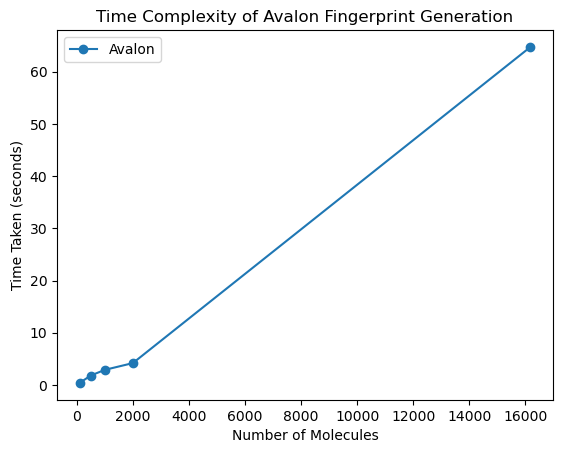

In [42]:
# Function to measure time for generating Avalon fingerprints
def measure_time_complexity_avalon(dataset, nBits=512):
    times = []
    sizes = [100, 500, 1000, 2000, len(dataset)]  # Adjust sizes based on dataset
    for size in sizes:
        subset = dataset[:size]  # Take the first 'size' molecules
        start_time = time.time()
        fingerprints = [pyAvalonTools.GetAvalonFP(mol, nBits=nBits) for mol in subset if mol is not None]
        end_time = time.time()
        times.append((size, end_time - start_time))
    return times

# Example usage (assuming hiv_data_ic50['structure'] contains RDKit Mol objects)
timing_results_avalon = measure_time_complexity_avalon(hiv_data_ic50['structure'])

# Convert results to DataFrame for visualization
timing_df_avalon = pd.DataFrame(timing_results_avalon, columns=['Dataset Size', 'Time Taken (s)'])
print(timing_df_avalon)

# Optional: Plot results
import matplotlib.pyplot as plt
plt.plot(timing_df_avalon['Dataset Size'], timing_df_avalon['Time Taken (s)'], marker='o', label='Avalon')
plt.xlabel('Number of Molecules')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Complexity of Avalon Fingerprint Generation')
plt.legend()
plt.show()

C:\Users\Gharat\AppData\Local\Temp\ipykernel_28096\4167448098.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


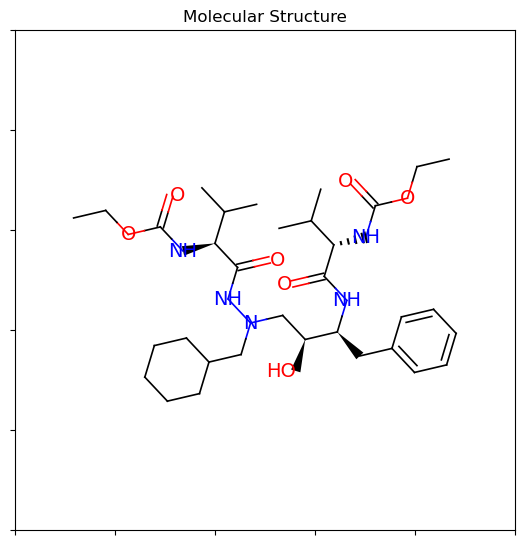

In [43]:
second_mol = hiv_data_ic50.iloc[1]['structure']

# Draw the molecule structure
Draw.MolToMPL(second_mol, size=(200, 200), kekulize=True)
plt.title('Molecular Structure')
# Show the plot
plt.tight_layout()
plt.show()

In [44]:
# Convert the first MACCS fingerprint to bit vector and print it as a binary string
second_avalon_fp = avalon_fps[0]  # Get the first fingerprint

# Convert the fingerprint to a bit string (binary representation)
bit_vector = list(second_avalon_fp.ToBitString())

# Print the bit vector as a binary string
print("Avalon Fingerprint (Bit Vector) for second molecule:")
print(''.join(bit_vector))  # Output as a string of 0s and 1s

# Optionally, if you want it as a list of integers:
bit_vector_int = [int(bit) for bit in bit_vector]
print("\nAvalon Fingerprint as list of integers:")
print(bit_vector_int)

Avalon Fingerprint (Bit Vector) for second molecule:
10100101000000011100010101000000011000000000100000000000011110000001010000101000100010101000001000001000100000010110001001000110000010010010000001000000010001000000000000000010110001000100000000001011010001000010101000010010110010000000000000000110011100000011001001000000000000000010111101000101000100000100000000000010001100000000001001001111010000010010000100000100000011110010000000000110000100000000000101000011000000000000000000000000010010000001101110000000100000000000000100000010101001000000010000000010

Avalon Fingerprint as list of integers:
[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,

In [45]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_avalon, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# Prepare DataFrame to store results
results = []

# Loop over models
for model_name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Append the results to the dataframe
    results.append({
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

               Model       MAE       MSE      RMSE        R²
0      Random Forest  0.589148  0.702946  0.838419  0.743410
1  Linear Regression  0.836358  1.139712  1.067573  0.583981
2                SVR  0.627257  0.768199  0.876469  0.719591
3  Gradient Boosting  0.821407  1.091319  1.044662  0.601645
4      Decision Tree  0.664448  1.100856  1.049217  0.598164


# Advantages and Disadvantages of Avalon Fingerprints

**Avalon** is a tool used for generating molecular fingerprints, which are binary representations of molecular structures. These fingerprints can be used for various cheminformatics tasks such as similarity searching, clustering, and predictive modeling. The **Avalon Fingerprint (AvalonFP)**, in particular, is widely used in the field of drug discovery and computational chemistry.

## Advantages of Avalon Fingerprints

1. **Efficient Representation**:
   - Avalon Fingerprints are compact binary vectors (typically 512 bits), which provide a concise representation of molecules, making them memory-efficient compared to other types of molecular descriptors like molecular graphs or SMILES strings.
   
2. **Scalability**:
   - Given their compact nature, Avalon Fingerprints can be used to efficiently handle large datasets. They scale well with the size of the database, making them useful in large-scale applications such as virtual screening of chemical libraries.

3. **Fast Comparisons**:
   - The binary representation allows for very fast similarity comparisons using bitwise operations. This makes it particularly useful for tasks like similarity searching, where quick identification of similar compounds is crucial.

4. **Robustness**:
   - Avalon Fingerprints are designed to be robust to small changes in molecular structure, allowing for good performance in tasks like virtual screening or clustering, where minor variations in molecules may still retain the same fingerprint.

5. **Descriptive Power**:
   - Despite being a binary vector, Avalon Fingerprints encode a significant amount of chemical information, capturing important structural features of molecules, such as functional groups, rings, and substructures.

6. **Widely Used**:
   - Avalon is widely adopted in computational chemistry and drug discovery workflows. It integrates well with other popular cheminformatics tools and libraries like RDKit and Open Babel, making it easy to incorporate into existing pipelines.

7. **No Need for Explicit 3D Coordinates**:
   - Unlike some other descriptors (e.g., 3D fingerprints), Avalon Fingerprints only require 2D molecular structures, making them easier to calculate and faster to generate.

## Disadvantages of Avalon Fingerprints

1. **Loss of 3D Information**:
   - Avalon Fingerprints primarily focus on 2D structural features and do not capture 3D information, which may be critical in certain applications, such as those involving receptor-ligand interactions, where the three-dimensional conformation of molecules matters.

2. **Limited Chemical Specificity**:
   - While Avalon Fingerprints capture a lot of structural features, they might not capture all the fine-grained chemical information. For example, different molecules with similar functional groups may have identical or nearly identical fingerprints, making it difficult to differentiate them based on structure alone.

3. **Fixed Length**:
   - The fixed length of Avalon Fingerprints (typically 512 bits) means that they may not represent all molecules equally well. Some very complex molecules might not be represented as efficiently as simpler ones, leading to potential loss of information in certain cases.

4. **Sensitivity to Encoding Parameters**:
   - The quality of the fingerprint depends on the parameters used for encoding (such as the size of the bit vector, the type of hashing function, etc.). Incorrect choices of parameters can lead to less effective representations, which could negatively affect performance in similarity searches or clustering tasks.

5. **No Consideration for Molecular Properties**:
   - Avalon Fingerprints are purely structural and do not account for the physicochemical properties or biological activity of molecules. This limits their usefulness for predictive modeling tasks that require an understanding of how the structure relates to specific molecular properties or activities.

6. **Not Ideal for All Types of Similarity Searches**:
   - For some applications, especially those involving subtle structural differences (such as activity cliffs in drug discovery), Avalon Fingerprints may not be discriminative enough. More advanced methods like 3D fingerprints or molecular graph-based methods may be better suited for these tasks.

7. **Interpretability**:
   - The binary nature of Avalon Fingerprints makes them difficult to interpret directly. It is challenging to understand the chemical meaning of a specific bit or combination of bits, which makes explaining the results of similarity searches or clustering based on these fingerprints non-trivial.

## Summary of Pros and Cons

| **Advantages**                                   | **Disadvantages**                                  |
|--------------------------------------------------|---------------------------------------------------|
| Efficient and compact representation of molecules | Loss of 3D information                            |
| Fast similarity comparisons                      | Limited chemical specificity                      |
| Scalable for large datasets                      | Fixed length may not represent complex molecules well |
| Robust to small changes in structure             | Sensitive to encoding parameters                  |
| Captures important structural features           | No direct consideration of molecular properties   |
| Widely adopted in cheminformatics                | Less effective for certain types of similarity searches |
| Does not require 3D coordinates                  | Hard to interpret individual bits in the fingerprint |

## Conclusion

Avalon Fingerprints are a popular and effective tool for many cheminformatics tasks, especially those involving large-scale data processing and fast molecular similarity comparisons. However, they have limitations, particularly in tasks requiring 3D information, detailed chemical specificity, or predictive modeling. Depending on the specific requirements of the application, it may be necessary to combine Avalon Fingerprints with other descriptors or methods to achieve optimal results.

---

# Atom-Pair Fingerprints and Their Use in Binding Affinity Prediction

### Overview of Atom-Pair Fingerprints

**Atom-Pair Fingerprints** are a type of molecular descriptor used to represent the structural features of a molecule by considering the relationships between pairs of atoms in the molecule. These fingerprints focus on the distances and types of interactions between pairs of atoms, which can provide valuable information about the spatial arrangement and connectivity of atoms. Atom-pair fingerprints are widely used in cheminformatics and are especially useful for tasks like similarity searching, virtual screening, and binding affinity prediction.

Atom-pair fingerprints are generated by first identifying all possible pairs of atoms in a molecule and then encoding the information about the distance and types of bonds between them. These descriptors are often hashed into a fixed-length bit vector, which allows for efficient comparison and manipulation of molecular data.

### Key Features of Atom-Pair Fingerprints

- **Pairwise Atom Relationships**: Atom-pair fingerprints capture the relationships between pairs of atoms, including information about the types of atoms involved, the bond order, and the distance between the atoms.
- **Distance Information**: One of the key aspects of atom-pair fingerprints is the inclusion of distance information. The distance between atoms, whether covalent or non-covalent, is an important feature for understanding molecular interactions, especially in the context of binding affinity prediction.
- **Binary Encoding**: Like other molecular fingerprints, atom-pair fingerprints are typically encoded as binary vectors, where each bit represents the presence or absence of a specific atom-pair feature in the molecule.
- **Hashing-Based Encoding**: Atom-pair fingerprints are often generated through hashing techniques that map each atom-pair feature to a specific index in the fingerprint, resulting in a fixed-length binary vector representation.
- **Customizable Length**: The length of the atom-pair fingerprint (e.g., 512 or 1024 bits) can be customized, allowing the user to control the tradeoff between the level of detail captured and computational efficiency.

### Application of Atom-Pair Fingerprints in Binding Affinity Prediction

In **binding affinity prediction**, the goal is to estimate how strongly a ligand (small molecule) binds to a target protein. This prediction is crucial in drug discovery, as it helps identify potential drug candidates based on their binding affinity to a specific protein target.

#### How Atom-Pair Fingerprints Help in Binding Affinity Prediction

1. **Capture of 3D Structural Information**:
   Atom-pair fingerprints consider the distances between pairs of atoms, which allows them to capture important 3D structural information about the molecule. This is crucial for predicting how the ligand will interact with the target protein's binding site, as the binding affinity is heavily influenced by the 3D spatial arrangement of the ligand.

2. **Identification of Important Structural Motifs**:
   Atom-pair fingerprints are particularly effective in identifying specific structural motifs and interactions that may contribute to binding affinity, such as hydrophobic interactions, hydrogen bonding, and electrostatic forces. These features can help machine learning models learn the key structural characteristics that influence binding strength.

3. **Feature-Rich Representation**:
   Atom-pair fingerprints are relatively feature-rich compared to simpler 2D descriptors, as they include information about the spatial arrangement of atoms. This richer representation allows machine learning models to make more accurate predictions about the binding affinity of a ligand to a protein target.

4. **Compatibility with Machine Learning**:
   Atom-pair fingerprints are widely used in machine learning models for binding affinity prediction, such as **Random Forests**, **Support Vector Machines (SVM)**, and **Neural Networks**. By training a model on a dataset of ligands and their corresponding binding affinities, the model can learn to associate specific atom-pair features with high or low binding affinity.

5. **Scalability and Efficiency**:
   Atom-pair fingerprints are efficient to compute and relatively compact, making them suitable for use with large datasets. Their binary encoding allows for fast comparisons, enabling large-scale virtual screening of compound libraries and quick prediction of binding affinities.

### Practical Example: Using Atom-Pair Fingerprints for Binding Affinity Prediction

1. **Generate Atom-Pair Fingerprints**:
   For each molecule in the dataset, generate its atom-pair fingerprint using tools like RDKit. This involves converting the molecule into an RDKit object and then generating the atom-pair fingerprint.

   ```python
   from rdkit.Chem import rdMolDescriptors
   from rdkit import Chem
   import numpy as np

   # Example molecule (SMILES notation)
   mol = Chem.MolFromSmiles('CC(C)CC1=CC=CC=C1')  # Example SMILES for a molecule

   # Generate Atom-Pair Fingerprint with 512 bits
   AP_fp = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=512)

   # Convert the fingerprint to a list for machine learning models
   AP_fp_list = list(AP_fp)

   # Print the Atom-Pair Fingerprint
   print(np.array(AP_fp_list))

In [48]:
# Function to generate Atom-Pair Fingerprints
def get_atom_pair_fingerprint(mol):
    return rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=512)

# Extract Atom-Pair fingerprints from the structure column
atom_fps = []
for mol in hiv_data_ic50['structure']:
    if mol is not None:
        # Generate Atom-Pair fingerprint (no need to convert SMILES as 'mol' is already a Mol object)
        fp = get_atom_pair_fingerprint(mol)
        atom_fps.append(fp)
    else:
        atom_fps.append(None)

# Convert the Atom-Pair fingerprints to a DataFrame (remove None entries)
X_atom_pair = pd.DataFrame([list(np.array(fp)) for fp in atom_fps if fp is not None])

[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION WARNING: please use AtomPairGenerator
[09:43:23] DEPRECATION W

[09:45:13] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:13] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:13] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:13] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION WARNING: please use AtomPairGenerator
[09:45:14] DEPRECATION W

   Dataset Size  Time Taken (s)
0           100        0.046816
1           500        0.204532
2          1000        0.269629
3          2000        0.461243
4         16179        4.005191


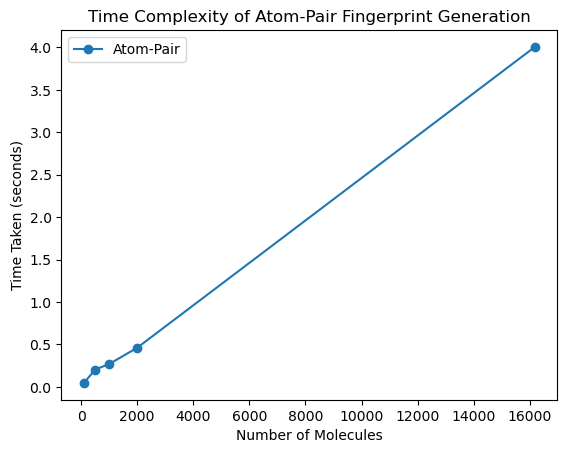

In [49]:
# Function to measure time for generating Atom-Pair fingerprints
def measure_time_complexity_atom_pair(dataset, nBits=512):
    times = []
    sizes = [100, 500, 1000, 2000, len(dataset)]  # Adjust sizes based on dataset
    for size in sizes:
        subset = dataset[:size]  # Take the first 'size' molecules
        start_time = time.time()
        fingerprints = [rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=nBits) for mol in subset if mol is not None]
        end_time = time.time()
        times.append((size, end_time - start_time))
    return times

# Example usage (assuming hiv_data_ic50['structure'] contains RDKit Mol objects)
timing_results_atom_pair = measure_time_complexity_atom_pair(hiv_data_ic50['structure'])

# Convert results to DataFrame for visualization
timing_df_atom_pair = pd.DataFrame(timing_results_atom_pair, columns=['Dataset Size', 'Time Taken (s)'])
print(timing_df_atom_pair)

# Optional: Plot results
import matplotlib.pyplot as plt
plt.plot(timing_df_atom_pair['Dataset Size'], timing_df_atom_pair['Time Taken (s)'], marker='o', label='Atom-Pair')
plt.xlabel('Number of Molecules')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Complexity of Atom-Pair Fingerprint Generation')
plt.legend()
plt.savefig('atom_pair_fingerprint_time_complexity.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
X_atom_pair.head()

0    1    2    3    4    5    6    7    8    9    ...  502  503  504  505  \
0    1    1    1    1    1    1    1    1    1    1  ...    1    0    1    1   
1    1    1    1    1    1    1    1    1    1    1  ...    1    0    1    1   
2    1    1    1    1    1    1    1    1    1    1  ...    1    0    1    1   
3    1    1    1    1    1    1    1    1    1    1  ...    1    0    1    1   
4    1    1    1    1    1    1    1    1    1    1  ...    1    0    1    1   

   506  507  508  509  510  511  
0    1    1    1    1    1    0  
1    1    1    1    1    1    0  
2    1    1    1    1    1    0  
3    1    1    1    1    1    1  
4    1    1    1    1    1    1  

[5 rows x 512 columns]

C:\Users\Gharat\AppData\Local\Temp\ipykernel_28096\1041884464.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


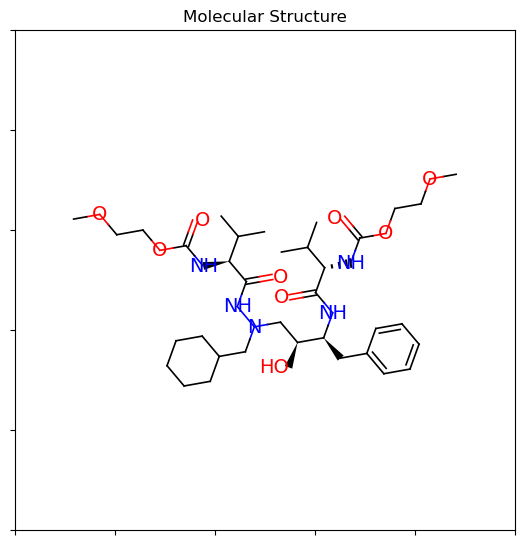

In [51]:
third_mol = hiv_data_ic50.iloc[2]['structure']

# Draw the molecule structure
Draw.MolToMPL(third_mol, size=(200, 200), kekulize=True)
plt.title('Molecular Structure')
# Show the plot
plt.tight_layout()
plt.show()

In [52]:
# Convert the first MACCS fingerprint to bit vector and print it as a binary string
third_atom_fp = atom_fps[2]  # Get the first fingerprint

# Convert the fingerprint to a bit string (binary representation)
bit_vector = list(third_atom_fp.ToBitString())

# Print the bit vector as a binary string
print("Atom-Pair Fingerprint (Bit Vector) for second molecule:")
print(''.join(bit_vector))  # Output as a string of 0s and 1s

# Optionally, if you want it as a list of integers:
bit_vector_int = [int(bit) for bit in bit_vector]
print("\nAtom-Pair Fingerprint as list of integers:")
print(bit_vector_int)

Atom-Pair Fingerprint (Bit Vector) for second molecule:
11111111111111111111110011111110111011111111111111111110111111111110111111101111000011110000111011111111111111111100111111101111110011001110111111001000111011101000111010001110111011100000110011111111111111111111111011111111111111101110111011101111110011111111111111111111111111101000111111111110111111111111111111101111111111111111111111101111111011001111111111111111111111101111110011111100110011000000111010000000111000001110110000001110111111101111111111111111111011111111111011111111111111111111111011111110

Atom-Pair Fingerprint as list of integers:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,

In [53]:
# Define target variable (assuming it's in a column named 'value')
y = hiv_data_ic50['pIC50']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_atom_pair, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# Prepare DataFrame to store results
results = []

# Loop over models
for model_name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Append the results to the dataframe
    results.append({
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

               Model       MAE       MSE      RMSE        R²
0      Random Forest  0.652718  0.820189  0.905643  0.700613
1  Linear Regression  0.910680  1.345430  1.159927  0.508889
2                SVR  0.676882  0.880692  0.938452  0.678529
3  Gradient Boosting  0.892246  1.251952  1.118907  0.543011
4      Decision Tree  0.734825  1.275407  1.129339  0.534449


## Advantages and Disadvantages of Atom-Pair Fingerprints

### Advantages of Atom-Pair Fingerprints

1. **Structural Sensitivity**:
   - Atom-Pair fingerprints encode pairs of atoms along with their bonding information, which allows them to capture important structural information about molecular interactions and connectivity.
   - They are particularly effective at representing molecular features relevant to 3D shape, atomic environment, and local interactions.

2. **Rich Representation of Molecular Features**:
   - These fingerprints capture both local and global structural features of a molecule, which makes them suitable for various tasks like similarity searching, clustering, and classification.

3. **Good Performance in Similarity Search**:
   - Atom-Pair fingerprints are often used in similarity searching because they provide a compact and efficient representation of molecules that is well-suited for comparing structural similarity between compounds.

4. **Efficient for Molecular Modeling**:
   - The bit-vector format of Atom-Pair fingerprints allows them to be used in machine learning and cheminformatics applications where computational efficiency is important, such as large-scale compound screening.

5. **Flexibility in Fingerprint Length**:
   - Atom-Pair fingerprints can be generated with different bit-lengths (e.g., 256, 512, 1024), giving users the flexibility to balance computational cost and the level of detail captured by the fingerprint.


### Disadvantages of Atom-Pair Fingerprints

1. **Loss of 3D Information**:
   - While Atom-Pair fingerprints capture atom pairs and bonding information, they are typically 2D descriptors, which means they may not fully capture 3D structural details and molecular flexibility. This can be a limitation for systems where 3D interactions are important.

2. **Possible Information Loss**:
   - Atom-Pair fingerprints simplify molecular information into pairs of atoms, which might cause some loss of detailed structural data, such as specific atomic positions, 3D conformation, or subtle electronic features.

3. **Limited to Local Interactions**:
   - Atom-Pair fingerprints focus on local atomic pairs and do not fully capture long-range interactions or more complex, non-local features of molecular structures, such as extended conjugation networks or long-range electrostatic effects.

4. **Dependency on Atom Pairs**:
   - The generation of Atom-Pair fingerprints is heavily dependent on the chosen pairs of atoms. If important atom pairs are not well-represented or considered, it may lead to an incomplete or less accurate representation of the molecule's characteristics.

5. **Potential for High Dimensionality**:
   - When using a high bit-length, the number of unique bit patterns grows rapidly. While this increases the fingerprint’s resolution, it can also lead to high-dimensional feature spaces, which may require dimensionality reduction techniques to avoid overfitting and improve model interpretability.

6. **Lack of Chemical Context**:
   - Atom-Pair fingerprints don't inherently capture the chemical context or functional groups as effectively as some other fingerprinting methods (e.g., Avalon or MACCS keys), making them less informative for certain types of structure-activity relationship (SAR) modeling tasks.


In summary, **Atom-Pair Fingerprints** are a valuable tool in molecular representation, particularly for similarity searching and local structure analysis. However, their inability to fully capture 3D features and more complex molecular contexts can be a limitation in some advanced applications.

---

# Topological Torsional Fingerprints and Their Use in Binding Affinity Prediction

### Overview of Topological Torsional Fingerprints

**Topological Torsional Fingerprints** are a type of molecular descriptor used to represent the 2D structure of a molecule based on its torsional features. These fingerprints focus on capturing the torsional (rotational) degrees of freedom between atoms in a molecule, which can provide valuable information about its flexibility and potential binding interactions with a target protein. Topological torsional fingerprints are particularly useful in cheminformatics for similarity searching, virtual screening, and binding affinity prediction.

The generation of topological torsional fingerprints involves identifying torsion angles in the molecule's structure, where the torsion is defined as the rotational degree of freedom between atoms connected by single bonds. The torsion angles are then used to encode the molecular information into a fixed-length bit vector, allowing for efficient comparisons between molecules.

### Key Features of Topological Torsional Fingerprints

- **Torsional Information**: Topological torsional fingerprints capture the torsion angles between atoms, which are crucial for understanding a molecule's flexibility and its ability to interact with a protein target's binding site.
- **Rotation and Conformation**: The torsional features encoded in the fingerprint reflect the possible rotational conformations of the molecule, which can impact its binding affinity by influencing the accessibility of functional groups and the overall shape of the molecule.
- **Binary Encoding**: Like other molecular fingerprints, topological torsional fingerprints are represented as binary vectors, where each bit corresponds to a specific torsional feature present in the molecule.
- **Hashing-Based Encoding**: The torsional information is typically mapped into a fixed-length bit vector through a hashing technique, which allows for efficient storage and comparison of molecular data.
- **Customizable Length**: The length of the topological torsional fingerprint (e.g., 512 or 1024 bits) can be adjusted based on the desired trade-off between computational efficiency and the level of detail captured by the fingerprint.

### Application of Topological Torsional Fingerprints in Binding Affinity Prediction

In **binding affinity prediction**, the goal is to estimate the strength with which a ligand (small molecule) binds to a target protein. This prediction is essential in drug discovery, as it helps identify potential drug candidates based on their binding strength to a specific protein target.

#### How Topological Torsional Fingerprints Help in Binding Affinity Prediction

1. **Capture of Molecular Flexibility**:
   Topological torsional fingerprints capture the rotational flexibility of a molecule by encoding its torsion angles. This flexibility is crucial for binding affinity prediction, as the binding strength between a ligand and its target protein is influenced by how well the ligand can adapt its conformation to fit the binding site.

2. **Representation of Conformational Diversity**:
   These fingerprints provide insight into the conformational diversity of a molecule. Ligands with more favorable torsional flexibility may be better able to bind to the target protein, leading to stronger binding affinity. By capturing this flexibility, topological torsional fingerprints can help predict the likelihood of strong binding interactions.

3. **Feature-Rich Representation**:
   Topological torsional fingerprints encode torsional information that adds an extra layer of structural detail compared to simpler 2D descriptors. This richer feature set helps machine learning models learn the complex relationships between a ligand's structure and its binding affinity.

4. **Compatibility with Machine Learning**:
   Topological torsional fingerprints are compatible with machine learning algorithms like **Random Forests**, **Support Vector Machines (SVM)**, and **Neural Networks**. By training models on datasets of ligands and their corresponding binding affinities, machine learning models can learn to associate torsional features with high or low binding affinity.

5. **Scalability and Efficiency**:
   Like other molecular fingerprints, topological torsional fingerprints are relatively computationally efficient and scalable, making them suitable for large-scale virtual screening and binding affinity prediction tasks. Their binary encoding allows for fast comparison and analysis of large compound libraries.

### Practical Example: Using Topological Torsional Fingerprints for Binding Affinity Prediction

1. **Generate Topological Torsional Fingerprints**:
   For each molecule in the dataset, generate its topological torsional fingerprint using tools like RDKit. This involves converting the molecule into an RDKit object and then generating the fingerprint.

   ```python
   from rdkit.Chem import rdMolDescriptors
   from rdkit import Chem
   import numpy as np

   # Example molecule (SMILES notation)
   mol = Chem.MolFromSmiles('CC(C)CC1=CC=CC=C1')  # Example SMILES for a molecule

   # Generate Topological Torsional Fingerprint with 512 bits
   torsional_fp = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=512)

   # Convert the fingerprint to a list for machine learning models
   torsional_fp_list = list(torsional_fp)

   # Print the Topological Torsional Fingerprint
   print(np.array(torsional_fp_list))


In [56]:
# Generate Topological Torsion Fingerprints
def get_topo_torsions_fingerprint(mol):
    return rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=512)

# Extract Topological Torsion fingerprints
topo_torsions_fps = [get_topo_torsions_fingerprint(mol) for mol in hiv_data_ic50['structure']]

# Convert to a dataframe
X_topo_torsions = pd.DataFrame([list(topo_torsions) for topo_torsions in topo_torsions_fps])

[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION WARNING: please use AtomPairGenerator
[09:50:01] DEPRECATION W

[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50:16] DEPRECATION WARNING: please use TopologicalTorsionGenerator
[09:50

   Dataset Size  Time Taken (s)
0           100        0.059334
1           500        0.254402
2          1000        0.430370
3          2000        0.765953
4         16179        6.434662


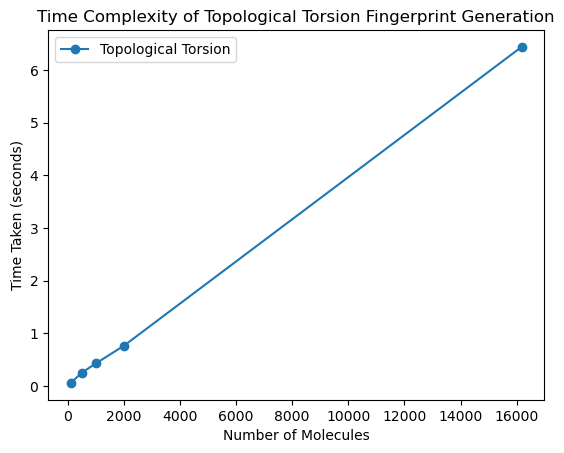

In [57]:
# Function to measure time for generating Topological Torsion fingerprints
def measure_time_complexity_topo_torsions(dataset, nBits=512):
    times = []
    sizes = [100, 500, 1000, 2000, len(dataset)]  # Adjust sizes based on dataset
    for size in sizes:
        subset = dataset[:size]  # Take the first 'size' molecules
        start_time = time.time()
        fingerprints = [rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=nBits) for mol in subset if mol is not None]
        end_time = time.time()
        times.append((size, end_time - start_time))
    return times

# Example usage (assuming hiv_data_ic50['structure'] contains RDKit Mol objects)
timing_results_topo_torsions = measure_time_complexity_topo_torsions(hiv_data_ic50['structure'])

# Convert results to DataFrame for visualization
timing_df_topo_torsions = pd.DataFrame(timing_results_topo_torsions, columns=['Dataset Size', 'Time Taken (s)'])
print(timing_df_topo_torsions)

# Optional: Plot results
import matplotlib.pyplot as plt
plt.plot(timing_df_topo_torsions['Dataset Size'], timing_df_topo_torsions['Time Taken (s)'], marker='o', label='Topological Torsion')
plt.xlabel('Number of Molecules')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Complexity of Topological Torsion Fingerprint Generation')
plt.legend()
plt.savefig('topological_fingerprint_time_complexity.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Gharat\AppData\Local\Temp\ipykernel_28096\571771073.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


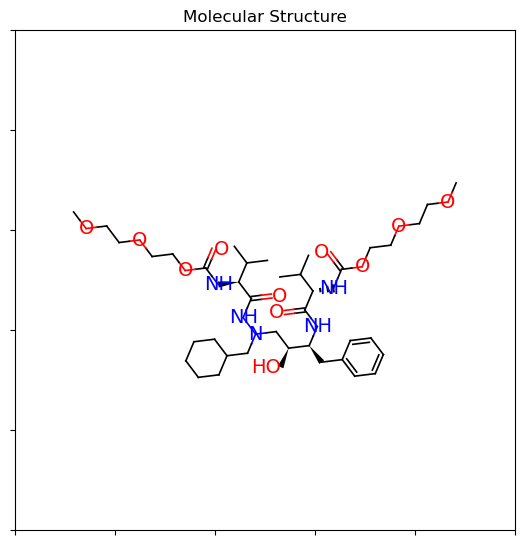

In [58]:
fourth_mol = hiv_data_ic50.iloc[3]['structure']

# Draw the molecule structure
Draw.MolToMPL(fourth_mol, size=(200, 200), kekulize=True)
plt.title('Molecular Structure')
# Show the plot
plt.tight_layout()
plt.show()

In [59]:
# Convert the first MACCS fingerprint to bit vector and print it as a binary string
fourth_fp = topo_torsions_fps[3]  # Get the first fingerprint

# Convert the fingerprint to a bit string (binary representation)
bit_vector = list(fourth_fp.ToBitString())

# Print the bit vector as a binary string
print("Topological Fingerprint (Bit Vector) for second molecule:")
print(''.join(bit_vector))  # Output as a string of 0s and 1s

# Optionally, if you want it as a list of integers:
bit_vector_int = [int(bit) for bit in bit_vector]
print("\nTopological Fingerprint as list of integers:")
print(bit_vector_int)

Topological Fingerprint (Bit Vector) for second molecule:
11111111111111111111110011111110111111111111111111111111111111111111111111101111000011100000111111111111111111111110111111101111111011101110111111001100111011101000111011101111111011100000110011111111111111111111111111111111111111111111111111001111111011111111111111111111111111111000111111111111111111111111111111111111111011111110111111111111111011001111111111111111111111101110110011111110111011100000111011100000111000001110111000001110111111101111111111111111111011111111111011111111111111111111111011111111

Topological Fingerprint as list of integers:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1

In [60]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_topo_torsions, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# Prepare DataFrame to store results
results = []

# Loop over models
for model_name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Append the results to the dataframe
    results.append({
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

               Model       MAE       MSE      RMSE        R²
0      Random Forest  0.652718  0.820189  0.905643  0.700613
1  Linear Regression  0.910680  1.345430  1.159927  0.508889
2                SVR  0.676882  0.880692  0.938452  0.678529
3  Gradient Boosting  0.892246  1.251952  1.118907  0.543011
4      Decision Tree  0.734825  1.275407  1.129339  0.534449


# Advantages and Disadvantages of Topological Fingerprints

**Topological fingerprints** are widely used in cheminformatics and computational drug discovery due to their ability to represent a molecule's 2D structure in a compact and computationally efficient way. However, like all molecular descriptors, they come with both advantages and limitations. Below is a detailed discussion of the **advantages** and **disadvantages** of topological fingerprints.

## **Advantages of Topological Fingerprints**

1. **Simplicity and Efficiency**:
   - **Easy to Compute**: Topological fingerprints are straightforward to compute using standard cheminformatics tools like RDKit. The computation involves encoding atomic connections (bonds) and other topological features of the molecule into a fixed-length binary vector.
   - **Computationally Efficient**: These fingerprints are typically represented as binary vectors, which allows for fast storage, comparison, and calculation. Their compact nature makes them suitable for large-scale data processing, such as virtual screening and molecular database searching.

2. **Generality and Versatility**:
   - **Applicable to Any Molecule**: Topological fingerprints can be generated for a wide variety of molecules, regardless of their size, complexity, or 3D conformation. This makes them versatile and useful in different types of molecular analyses (e.g., similarity searching, clustering, etc.).
   - **Minimal Structural Requirements**: These fingerprints only require 2D information, such as atoms and bonds, making them suitable even for cases where 3D information is not available or not necessary.

3. **High Predictive Power**:
   - **Capture of Key Structural Features**: Topological fingerprints capture essential structural information such as the connectivity of atoms, rings, and functional groups. This allows them to be effective in tasks like molecular similarity analysis and predicting biological activity, including binding affinity.
   - **Compatibility with Machine Learning**: Topological fingerprints work well with machine learning algorithms (e.g., Random Forests, Support Vector Machines, Neural Networks) because they are binary, fixed-length, and can encode a variety of structural information.

4. **Scalability**:
   - **Scalable for Large Datasets**: Due to their binary nature and efficient computation, topological fingerprints can be scaled to large molecular datasets, which is essential in high-throughput drug screening and virtual screening applications.

5. **Interpretability**:
   - **Understandable Structural Representation**: These fingerprints provide a simple representation of the molecular structure, which can be useful in understanding the relationships between molecular structure and biological activity. 


## **Disadvantages of Topological Fingerprints**

1. **Lack of 3D Structural Information**:
   - **No 3D Conformational Details**: Topological fingerprints primarily capture the 2D structure of molecules, which means they do not account for 3D conformational changes that may be important for understanding molecular interactions, especially in the case of protein-ligand binding or complex molecular recognition.
   - **Limited Flexibility Representation**: While topological fingerprints encode information about atomic connectivity and ring structures, they often miss the flexibility of molecules, such as torsional rotations, which can play a significant role in binding affinity and molecular recognition.

2. **Loss of Chemical Context**:
   - **No Specific Chemical Properties**: These fingerprints focus on the connectivity and topology of the molecule and may not explicitly capture important chemical properties like electrostatic charge, partial charges, or specific types of interactions (hydrogen bonds, hydrophobic effects). As a result, molecules that differ in terms of subtle chemical features may be assigned similar topological fingerprints.
   
3. **Information Loss Due to Hashing**:
   - **Hashing and Loss of Detailed Information**: Many topological fingerprinting methods use hashing techniques to map the structural information into a fixed-length bit vector. This can cause **information loss**, as multiple distinct molecular features may map to the same bit in the fingerprint, leading to possible false similarities between structurally dissimilar molecules.

4. **Limited Discrimination Power in Complex Cases**:
   - **Difficulty in Discriminating Complex Structures**: While topological fingerprints are effective in identifying structural similarities between small molecules, they may struggle to differentiate between molecules that have similar topological features but exhibit different pharmacological behaviors. In cases where subtle structural differences matter (e.g., subtle variations in binding affinity), topological fingerprints may not provide sufficient discrimination.
   
5. **Sparse or Binary Nature**:
   - **Binary Representation**: The binary nature of topological fingerprints means that they often do not provide a continuous or detailed quantitative description of molecular structure, which might limit their ability to fully capture the richness of certain chemical features or predict continuous properties like exact binding affinities or other quantitative biological outcomes.

6. **Dependence on Molecular Size and Complexity**:
   - **Effectiveness for Small to Medium Molecules**: Topological fingerprints are often more effective for smaller molecules with relatively simple structures. As the size and complexity of molecules increase, the number of potential features increases, and topological fingerprints may become less informative or may require higher bit-lengths (more computationally intensive) to adequately capture the necessary structural details.


## **Conclusion**

Topological fingerprints are widely used for molecular similarity searching, virtual screening, and feature extraction in cheminformatics. They offer several advantages, including computational efficiency, versatility, and scalability. However, they also have notable limitations, especially with regard to 3D structural information, subtle chemical features, and information loss due to hashing. Despite these disadvantages, topological fingerprints remain a powerful tool, particularly when combined with other descriptors or 3D-based techniques for more comprehensive molecular analysis.

---

# Morgan Fingerprints and Their Use in Binding Affinity Prediction

### Overview of Morgan Fingerprints

**Morgan fingerprints**, also known as extended-connectivity fingerprints (ECFPs), are among the most widely used molecular descriptors in cheminformatics. They represent molecules based on their atomic connectivity and the local chemical environment of each atom. Morgan fingerprints are particularly effective for tasks such as similarity searching, virtual screening, and binding affinity prediction because of their ability to capture detailed structural information in a computationally efficient format.

The generation of Morgan fingerprints involves iteratively encoding atomic neighborhoods into a fixed-length binary vector. This process creates a representation that captures the connectivity and environment of atoms up to a defined radius. Each bit in the fingerprint corresponds to the presence or absence of specific substructures in the molecule.

### Key Features of Morgan Fingerprints

- **Circular Representation**: Morgan fingerprints capture the local chemical environment of atoms by encoding atom-centered substructures within a defined radius.
- **Customizable Radius**: The radius (e.g., 2 or 3 bonds) defines the extent of the local environment considered for each atom, allowing flexibility in capturing molecular details.
- **Binary Encoding**: Morgan fingerprints are typically represented as binary vectors, where each bit corresponds to the presence of a particular substructure in the molecule.
- **Hashing-Based Encoding**: Substructures are hashed into a fixed-length bit vector (e.g., 1024 or 2048 bits), enabling efficient storage and comparison.
- **Highly Informative**: These fingerprints are well-suited for identifying molecular similarity and are widely used in predictive modeling tasks like binding affinity prediction.

### Application of Morgan Fingerprints in Binding Affinity Prediction

In **binding affinity prediction**, the goal is to estimate the strength with which a ligand (small molecule) binds to a target protein. Morgan fingerprints help capture the structural features of ligands that are crucial for their interactions with proteins, enabling machine learning models to predict binding strength effectively.

#### How Morgan Fingerprints Help in Binding Affinity Prediction

1. **Capturing Structural Information**:
   Morgan fingerprints encode detailed structural features, such as the presence of functional groups and their connectivity. These features are critical for understanding how a molecule interacts with a protein's binding site.

2. **Flexibility in Structural Granularity**:
   By adjusting the radius of the fingerprint, Morgan fingerprints can capture varying levels of molecular detail. Smaller radii focus on local environments, while larger radii capture more extensive connectivity information, which may influence binding affinity.

3. **Feature-Rich Representation**:
   The hashed representation of Morgan fingerprints provides a dense encoding of structural features, which enhances their utility in predictive tasks. This richness allows machine learning models to identify patterns related to binding affinity.

4. **Compatibility with Machine Learning**:
   Morgan fingerprints work well with machine learning algorithms, as they are binary, fixed-length, and capable of encoding diverse molecular features. This compatibility makes them ideal for binding affinity prediction tasks using algorithms such as **Random Forests**, **Gradient Boosting**, or **Neural Networks**.

5. **Scalability and Efficiency**:
   Like topological fingerprints, Morgan fingerprints are computationally efficient to generate and compare, making them suitable for large-scale virtual screening tasks in drug discovery.

---

### Practical Example: Using Morgan Fingerprints for Binding Affinity Prediction

Below is an example of how to generate Morgan fingerprints using RDKit for binding affinity prediction:

```python
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

# Example molecule (SMILES notation)
smiles = 'CC(C)CC1=CC=CC=C1'  # Example SMILES string for a molecule
mol = Chem.MolFromSmiles(smiles)  # Convert SMILES to RDKit molecule object

# Generate Morgan Fingerprint with radius 2 and 1024 bits
morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)

# Convert the fingerprint to a list for machine learning models
morgan_fp_list = list(morgan_fp)

# Print the Morgan Fingerprint
print(np.array(morgan_fp_list))


In [63]:
# Generate Morgan Circular Fingerprints
def get_morgan_fingerprint(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

# Extract Morgan fingerprints
morgan_fps = [get_morgan_fingerprint(mol) for mol in hiv_data_ic50['structure']]

# Convert to a dataframe
X_morgan = pd.DataFrame([list(morgan) for morgan in morgan_fps])

[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerator
[09:55:04] DEPRECATION WARNING: please use MorganGenerat

[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerator
[09:55:52] DEPRECATION WARNING: please use MorganGenerat

   Dataset Size  Time Taken (s)
0           100        0.025562
1           500        0.148793
2          1000        0.247499
3          2000        0.394382
4         16179        3.565281


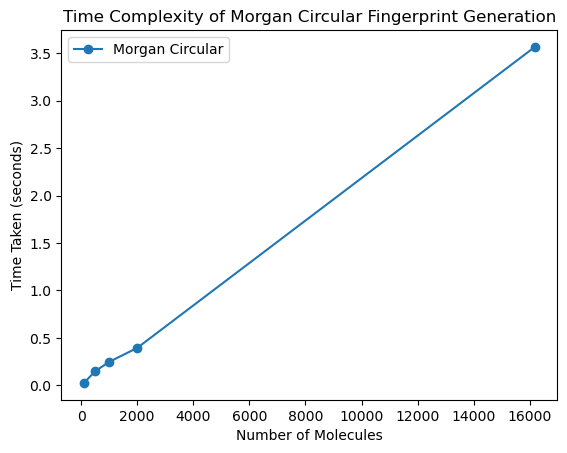

In [64]:
# Function to measure time for generating Morgan Circular fingerprints
def measure_time_complexity_morgan(dataset, radius=2, nBits=2048):
    times = []
    sizes = [100, 500, 1000, 2000, len(dataset)]  # Adjust sizes based on dataset
    for size in sizes:
        subset = dataset[:size]  # Take the first 'size' molecules
        start_time = time.time()
        fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits) for mol in subset if mol is not None]
        end_time = time.time()
        times.append((size, end_time - start_time))
    return times

# Example usage (assuming hiv_data_ic50['structure'] contains RDKit Mol objects)
timing_results_morgan = measure_time_complexity_morgan(hiv_data_ic50['structure'])

# Convert results to DataFrame for visualization
timing_df_morgan = pd.DataFrame(timing_results_morgan, columns=['Dataset Size', 'Time Taken (s)'])
print(timing_df_morgan)

# Optional: Plot results
import matplotlib.pyplot as plt
plt.plot(timing_df_morgan['Dataset Size'], timing_df_morgan['Time Taken (s)'], marker='o', label='Morgan Circular')
plt.xlabel('Number of Molecules')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Complexity of Morgan Circular Fingerprint Generation')
plt.legend()
plt.savefig('morgan_fingerprint_time_complexity.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Gharat\AppData\Local\Temp\ipykernel_28096\1453738400.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


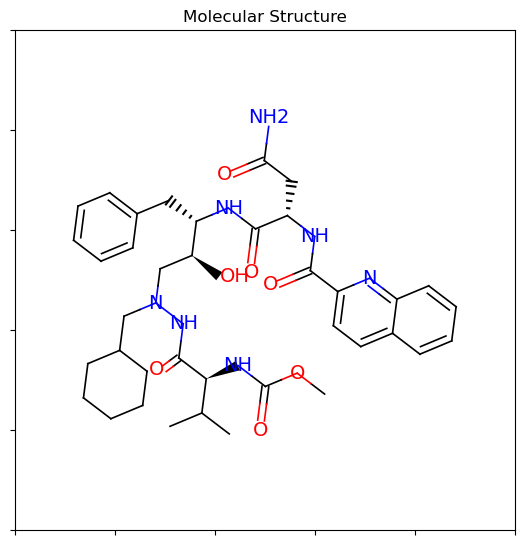

In [65]:
fifth_mol = hiv_data_ic50.iloc[4]['structure']

# Draw the molecule structure
Draw.MolToMPL(fifth_mol, size=(200, 200), kekulize=True)
plt.title('Molecular Structure')
# Show the plot
plt.tight_layout()
plt.show()

In [66]:
# Convert the first MACCS fingerprint to bit vector and print it as a binary string
fifth_fp = morgan_fps[4]  # Get the first fingerprint

# Convert the fingerprint to a bit string (binary representation)
bit_vector = list(fifth_fp.ToBitString())

# Print the bit vector as a binary string
print("Morgan Fingerprint (Bit Vector) for second molecule:")
print(''.join(bit_vector))  # Output as a string of 0s and 1s

# Optionally, if you want it as a list of integers:
bit_vector_int = [int(bit) for bit in bit_vector]
print("\nMorgan Fingerprint as list of integers:")
print(bit_vector_int)

Morgan Fingerprint (Bit Vector) for second molecule:
01100000000000001000000000000100000000000000000000000000000000000000000000000001100000000000000000000000100000000000010000000000000000000000100000000000000000000000000000000000000000000000000000000000000100000000000000000000000100000000000000000000000000000000000000000000000000000001000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000001010000000000100000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000001010000000000000000000010000000000000000000000000000000000000000000000000000000000000001010000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000100100000000000000000000000000000000000000001100000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000010010001000000000000010100000000000000000000000100000010100000000000000000000000000000000000100000000000000000000

In [67]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_morgan, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# Prepare DataFrame to store results
results = []

# Loop over models
for model_name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Append the results to the dataframe
    results.append({
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

               Model       MAE       MSE      RMSE        R²
0      Random Forest  0.575634  0.693236  0.832608  0.746954
1  Linear Regression  0.742520  0.952731  0.976079  0.652233
2                SVR  0.594882  0.719787  0.848403  0.737262
3  Gradient Boosting  0.854425  1.148367  1.071619  0.580821
4      Decision Tree  0.636219  0.962916  0.981283  0.648515


### Advantages and Disadvantages of Morgan Fingerprints

Morgan fingerprints, also known as extended-connectivity fingerprints (ECFPs), are widely used molecular descriptors due to their versatility and robustness. However, like any computational tool, they come with their own set of strengths and limitations.

#### **Advantages of Morgan Fingerprints**

1. **High Information Density**:
   - Morgan fingerprints efficiently encode detailed structural features of molecules, including atom connectivity and local environments.
   - Their hashed binary representation allows for compact storage while retaining critical molecular information.

2. **Customizable Granularity**:
   - The radius parameter can be adjusted to control the level of structural detail captured. Smaller radii focus on local atom environments, while larger radii include more extensive connectivity information.

3. **Widely Used and Validated**:
   - Morgan fingerprints are a standard in cheminformatics and have been extensively validated for tasks like similarity searching, virtual screening, and predictive modeling.

4. **Compatibility with Machine Learning**:
   - Their binary, fixed-length representation makes them ideal inputs for machine learning algorithms, enabling effective binding affinity prediction and other predictive tasks.

5. **Scalability and Efficiency**:
   - Morgan fingerprints are computationally efficient to compute and compare, making them suitable for large-scale datasets.

6. **Robust to Missing 3D Information**:
   - As 2D descriptors, Morgan fingerprints do not rely on the availability of 3D molecular conformations, simplifying their application in many cases.

7. **Open-Source Availability**:
   - Tools like RDKit provide free and easy-to-use implementations of Morgan fingerprint generation, promoting accessibility for researchers and developers.

#### **Disadvantages of Morgan Fingerprints**

1. **Loss of Context in Hashing**:
   - The hashing process can lead to collisions, where distinct molecular substructures map to the same bit. This reduces the specificity of the fingerprint in some cases.

2. **Fixed-Length Limitation**:
   - The fixed bit vector size can result in a trade-off between computational efficiency and the level of structural detail captured.

3. **Ignores 3D Information**:
   - Morgan fingerprints are purely 2D descriptors and do not capture 3D conformational information, which may be critical for accurately predicting properties like binding affinity.

4. **Sensitive to Substructure Absence**:
   - The absence of certain substructures may result in under-representation of critical molecular features, especially in datasets with highly diverse chemotypes.

5. **Requires Proper Radius Selection**:
   - Choosing an inappropriate radius can lead to loss of important structural details (if too small) or include irrelevant features (if too large).

6. **Limited Insight into Chemical Context**:
   - Morgan fingerprints do not explicitly encode chemical properties such as electronegativity or hydrophobicity, which may limit their performance in certain applications.

#### **Summary**
Morgan fingerprints are a robust and efficient tool for representing molecular structures, making them a popular choice in cheminformatics. However, users must be mindful of their limitations, such as loss of 3D information and sensitivity to parameter choices, when applying them to specific tasks.

---

# Hybrid Approach

In [70]:
# Concatenate all fingerprints except RDKit
X_hybrid = pd.concat([X_maccs, X_avalon, X_atom_pair, X_topo_torsions, X_morgan], axis=1)

# Print the shape of the data
X_hybrid.shape

(16179, 3751)

In [71]:
# Standardize the hybrid features
scaler = StandardScaler()
X_hybrid_scaled = scaler.fit_transform(X_hybrid)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_hybrid_pca = pca.fit_transform(X_hybrid_scaled)

# Optionally, print PCA explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance ratio by PCA components: {explained_variance}")
print(f"Number of components used: {pca.n_components_}")

Explained variance ratio by PCA components: [7.19314012e-02 2.62871904e-02 1.71399945e-02 ... 8.36395849e-05
 8.35767603e-05 8.34939731e-05]
Number of components used: 1515


In [72]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_hybrid_pca, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

# Prepare DataFrame to store results
results = []

# Loop over models
for model_name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Append the results to the dataframe
    results.append({
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

               Model       MAE       MSE      RMSE        R²
0      Random Forest  0.644113  0.786140  0.886645  0.713042
1  Linear Regression  0.721332  0.891440  0.944161  0.674605
2                SVR  0.590162  0.711736  0.843644  0.740201
3  Gradient Boosting  0.807551  1.056393  1.027810  0.614394
4      Decision Tree  0.776441  1.348994  1.161462  0.507588


---

### Best Performing Model

The **Random Forest model** paired with the **Morgan Circular Fingerprint (ECFP)** consistently delivers the best metrics:

- **Mean Absolute Error (MAE):** 0.575634        
- **Mean Squared Error (MSE):** 0.693236  
- **Root Mean Squared Error (RMSE):** 0.832608  
- **Coefficient of Determination (R²):** 0.746954

In [132]:
# The first 5 rows of the morgan fingerprint data
X_morgan.head()

0     1     2     3     4     5     6     7     8     9     ...  2038  \
0     0     1     1     0     0     0     0     0     0     0  ...     0   
1     0     1     1     0     0     0     0     0     0     0  ...     0   
2     0     1     1     0     0     0     0     0     0     0  ...     0   
3     0     1     1     0     0     0     0     0     0     0  ...     0   
4     0     1     1     0     0     0     0     0     0     0  ...     0   

   2039  2040  2041  2042  2043  2044  2045  2046  2047  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0     0  
3     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0  

[5 rows x 2048 columns]

In [135]:
# The first 5 roews of the target variable
print(y[:5])

2   -0.929419
3   -2.247973
4   -2.214844
5   -1.826075
6   -1.431364
Name: pIC50, dtype: float64


In [137]:
# Training the model on the whole dataset
best_predictor = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the final model with the whole data
best_predictor.fit(X_morgan, y)

RandomForestRegressor(random_state=42)

In [139]:
# Dictionary of small molecules with SMILES (Commonly used small molecules in HIV Treatment)
hiv_drug_smiles = {
    "Zidovudine (AZT)": "CC1=CN(C(=O)NC1=O)COCC2=CN=CN2",
    "Lamivudine (3TC)": "C1C(C(C(O1)N2C=CC(=NC2=O)N)O)O",
    "Emtricitabine (FTC)": "C1C(C(C(O1)N2C=CC(=NC2=O)N)O)SC3=CC=CC=C3",
    "Abacavir (ABC)": "CC1=C2C(N(CN2C3=NC=NC=C3)C=C1)O",
    "Tenofovir Disoproxil Fumarate (TDF)": "CCOC(=O)COC(=O)CN(P(=O)(OCC)OCC)CCO",
    "Efavirenz (EFV)": "C1CC2=C(C=C(C=C2)Cl)C3=C(C=CC=C3)N1C(=O)CF",
    "Nevirapine (NVP)": "C1=CC2=C(C=CC=N2)N3C1=CC=C3C",
    "Etravirine (ETR)": "C1=CC=C(C=C1)C2=C(C=CC(=C2)N(C3=CC(=CC=C3)C#N)C4=CC(=CC=C4)C#N)O",
    "Rilpivirine (RPV)": "CC(C)CN1C=C(C2=NC=NC=C21)C3=CC=C(C=C3)C#N",
    "Ritonavir (RTV)": "CCC(C)C(C(=O)NC(C(C(C)OC(=O)N1CCCC1C(=O)N)OC2=CC=CC=C2)OC3=CC=CC=C3)SC",
    "Lopinavir (LPV)": "CC(C)C(C(=O)NC(CC1=CC=CC=C1)C(=O)N2CCCC2)OC3=CC=CC=C3",
    "Atazanavir (ATV)": "CC1=NC2=C(C3=C(NC2=N1)N=C(N3)N)NC(C4=CC=CC=C4)C(=O)N",
    "Darunavir (DRV)": "CC1C(C(C(=O)NC(C(CC2=CC=CC=C2)NC(=O)CC3=CC=CC=C3)O1)OC)OC",
    "Raltegravir (RAL)": "CC1=C(O)C=C(C=C1C(C2=CC=CC=C2)C(=O)NC(CC3=CC=CC=C3)C(=O)O)C(=O)NO",
    "Elvitegravir (EVG)": "CC(C)C1=NC=C(N=C1C(C2=CC=CC=C2)C(=O)NC(CC3=CC=CC=C3)C(=O)O)O",
    "Dolutegravir (DTG)": "CC1=CC=C(C(=C1)C(C2=CC=CC=C2)C(=O)NC(CC3=CC=CC=C3)C(=O)O)O",
    "Bictegravir (BIC)": "CC(C1=NC(=NC2=C1N=C(N2)C3=CC=CC=C3)C4=CC=C(C=C4)F)C(=O)NC(CC5=CC=CC=C5)C(=O)O",
    "Maraviroc (MVC)": "CCC(C1=CC(=C(C=C1)C(C2=CC=CC=C2)C(=O)NC(CC3=CC=CC=C3)C(=O)N)O)N"
}

# Convert to a pandas DataFrame
hiv_drug_df = pd.DataFrame(list(hiv_drug_smiles.items()), columns=["Drug Name", "SMILES"])
hiv_drug_df.head(10)

Drug Name  \
0                     Zidovudine (AZT)   
1                     Lamivudine (3TC)   
2                  Emtricitabine (FTC)   
3                       Abacavir (ABC)   
4  Tenofovir Disoproxil Fumarate (TDF)   
5                      Efavirenz (EFV)   
6                     Nevirapine (NVP)   
7                     Etravirine (ETR)   
8                    Rilpivirine (RPV)   
9                      Ritonavir (RTV)   

                                              SMILES  
0                     CC1=CN(C(=O)NC1=O)COCC2=CN=CN2  
1                     C1C(C(C(O1)N2C=CC(=NC2=O)N)O)O  
2          C1C(C(C(O1)N2C=CC(=NC2=O)N)O)SC3=CC=CC=C3  
3                    CC1=C2C(N(CN2C3=NC=NC=C3)C=C1)O  
4                CCOC(=O)COC(=O)CN(P(=O)(OCC)OCC)CCO  
5         C1CC2=C(C=C(C=C2)Cl)C3=C(C=CC=C3)N1C(=O)CF  
6                       C1=CC2=C(C=CC=N2)N3C1=CC=C3C  
7  C1=CC=C(C=C1)C2=C(C=CC(=C2)N(C3=CC(=CC=C3)C#N)...  
8          CC(C)CN1C=C(C2=NC=NC=C21)C3=CC=C(C=C3)C#N  
9  CCC(C)C(C(=O)NC(C(C(C)OC(=O)N1CCCC1C(=O)N)OC2=...

In [141]:
# Convert the SMILES to Molecule Object in rdkit
hiv_drug_df['Mol'] = hiv_drug_df['SMILES'].apply(Chem.MolFromSmiles)

In [143]:
# Getting the Fingerprints of the molecules
hiv_drug_df['Fingerprint'] = hiv_drug_df['Mol'].apply(
    lambda mol: get_morgan_fingerprint(mol) if mol else None
)

# Printing the first 5 rows
hiv_drug_df.head()

[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerator
[13:40:31] DEPRECATION WARNING: please use MorganGenerat

Drug Name  \
0                     Zidovudine (AZT)   
1                     Lamivudine (3TC)   
2                  Emtricitabine (FTC)   
3                       Abacavir (ABC)   
4  Tenofovir Disoproxil Fumarate (TDF)   

                                      SMILES  \
0             CC1=CN(C(=O)NC1=O)COCC2=CN=CN2   
1             C1C(C(C(O1)N2C=CC(=NC2=O)N)O)O   
2  C1C(C(C(O1)N2C=CC(=NC2=O)N)O)SC3=CC=CC=C3   
3            CC1=C2C(N(CN2C3=NC=NC=C3)C=C1)O   
4        CCOC(=O)COC(=O)CN(P(=O)(OCC)OCC)CCO   

                                                 Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000001679A7...   
1  <rdkit.Chem.rdchem.Mol object at 0x000001679A7...   
2  <rdkit.Chem.rdchem.Mol object at 0x000001679A7...   
3  <rdkit.Chem.rdchem.Mol object at 0x000001679A7...   
4  <rdkit.Chem.rdchem.Mol object at 0x000001679A7...   

                                         Fingerprint  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [145]:
# Convert fingerprints into a feature matrix (DataFrame format)
X_drug_morgan = pd.DataFrame([list(fp) for fp in hiv_drug_df['Fingerprint'] if fp is not None])

In [147]:
# The first 5 rows of the X_drug_morgan
X_drug_morgan.head()

0     1     2     3     4     5     6     7     8     9     ...  2038  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     0   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     0     0     0     0     0     0  ...     0   

   2039  2040  2041  2042  2043  2044  2045  2046  2047  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     1     0     0     0     0     0  
2     0     0     0     1     0     0     0     0     0  
3     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0  

[5 rows x 2048 columns]

In [149]:
# The pIC50 values predicted by the model
hiv_drug_df['pIC50'] = best_predictor.predict(X_drug_morgan)

In [151]:
# Check whether the drug work or not
report = hiv_drug_df[['Drug Name', 'SMILES', 'pIC50']]

# Function to check the effectiveness
def classify_drug_effectiveness(pIC50_values, threshold=6.0):
    """
    Classify drugs as effective or not effective based on their pIC50 values.

    Parameters:
    - pIC50_values (list or pd.Series): A list or pandas Series of pIC50 values.
    - threshold (float): The pIC50 value above which drugs are considered effective.

    Returns:
    - classifications (list): A list of classifications ('Effective' or 'Not Effective').
    """
    return ["Effective" if pIC50 >= threshold else "Not Effective" for pIC50 in pIC50_values]

report['Effectiveness'] = classify_drug_effectiveness(report['pIC50'])

C:\Users\Gharat\AppData\Local\Temp\ipykernel_28096\931726947.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  report['Effectiveness'] = classify_drug_effectiveness(report['pIC50'])


In [153]:
## The first 5 rows of the report
report.head()

Drug Name  \
0                     Zidovudine (AZT)   
1                     Lamivudine (3TC)   
2                  Emtricitabine (FTC)   
3                       Abacavir (ABC)   
4  Tenofovir Disoproxil Fumarate (TDF)   

                                      SMILES     pIC50  Effectiveness  
0             CC1=CN(C(=O)NC1=O)COCC2=CN=CN2 -3.475166  Not Effective  
1             C1C(C(C(O1)N2C=CC(=NC2=O)N)O)O -3.748969  Not Effective  
2  C1C(C(C(O1)N2C=CC(=NC2=O)N)O)SC3=CC=CC=C3 -4.110475  Not Effective  
3            CC1=C2C(N(CN2C3=NC=NC=C3)C=C1)O -4.106735  Not Effective  
4        CCOC(=O)COC(=O)CN(P(=O)(OCC)OCC)CCO -4.584476  Not Effective

In [155]:
report['Effectiveness'].value_counts()  # Value distribution

Not Effective    18
Name: Effectiveness, dtype: int64

<Axes: xlabel='pIC50', ylabel='Density'>

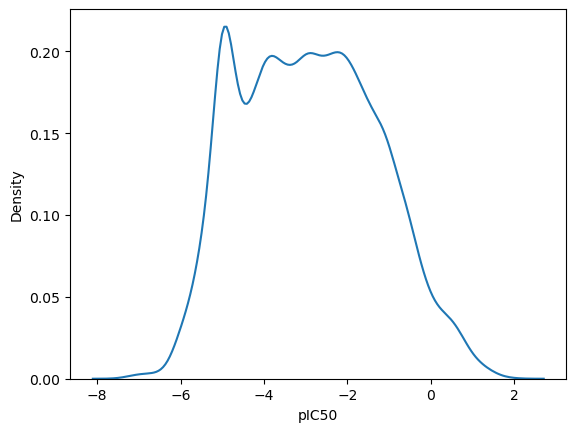

In [159]:
import seaborn as sns

# Plot of the distribution of the pIC50 values
sns.kdeplot(hiv_data_ic50['pIC50'])

In [161]:
hiv_data_ic50[hiv_data_ic50['pIC50']>6]  # Almost no rows with effective drugs

Empty DataFrame
Columns: [smiles, target_name, standard_type, value, pIC50, canonical_smiles, structure]
Index: []

In [169]:
report.to_csv('True_Drug_Test.csv', index=False)

## Future Scope

### 1. Enhanced Data Availability and Quality
- One of the key limitations in the current project is the lack of accurate and diverse binding affinity data. 
- Expanding the dataset by:
  - Curating experimental results from multiple sources.
  - Leveraging publicly available repositories such as BindingDB, PubChem, or ChEMBL.
- Collaborations with pharmaceutical organizations and research institutes can help acquire high-quality data, further improving model performance.

### 2. Integration of Deep Learning Models
- Investigate advanced models such as:
  - **Graph Neural Networks (GNNs)** for better molecular representation.
  - **Transformer-based architectures** for capturing complex molecular relationships.
- Explore unsupervised and semi-supervised learning techniques to utilize large amounts of unlabeled data effectively.

### 3. Real-Time Data Integration
- Enable dynamic updates by integrating real-time molecular and binding data through APIs.
- Link with cheminformatics databases like PubChem or ChEMBL to enhance data availability and user interactivity.

### 4. Broader Applicability
- Extend the framework to support prediction of binding affinities for a wider range of diseases, including:
  - Cancer
  - Diabetes
  - Rare genetic disorders
- Add functionalities for drug efficacy and toxicity analysis, providing a comprehensive drug discovery pipeline.

### 5. Computational Optimization
- Optimize the computational process by:
  - Exploring lightweight fingerprinting techniques for faster predictions.
  - Leveraging distributed computing and cloud platforms for handling large-scale datasets and computationally intensive models.

### 6. User-Centric Improvements
- Develop an interactive web platform with:
  - Advanced molecular visualizations.
  - Customization options for selecting fingerprints and models based on user requirements.
- Improve the overall user experience by ensuring intuitive interfaces and fast response times.

### 7. Incorporation of Experimental Validation
- Collaborate with wet lab researchers to validate predictions experimentally.
- Create a feedback loop for continuous refinement and validation of the machine learning models.

### 8. Regulatory and Ethical Considerations
- Address data privacy concerns, particularly when dealing with sensitive molecular and patient-related data.
- Ensure compliance with healthcare regulations to prepare the system for real-world applications.

---

By addressing these future directions, the project can evolve into a scalable, efficient, and impactful tool for drug discovery and personalized medicine.
